# Decision Tree and Random Forest


The features used for prediction are
* year: 2016 for all data points
* month: number for month of the year
* day: number for day of the year
* week: day of the week as a character string
* temp_2: max temperature 2 days prior
* temp_1: max temperature 1 day prior
* average: historical average max temperature
* forecast_noaa, forecast_acc, forecast_under: some forcast temperatures
* friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

The ground truth is stored as
actual: max temperature measurement

In this demo, we show how to predict the maximum temperature of tomorrow based on these features using a single decision tree and a random forest. We show the impact of hyperparameters on the testing set.  We also show the feature importance derived from the tree design process. You may have suspected already that some of the above features are not likely to be useful...

We first load some necessary library.

In [0]:
import pandas as pd
import numpy as np

Let us first take a look at the weather data we will use

In [3]:
features = pd.read_csv("temps.csv")
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


We also need to convert categorical variables, days of the week, to a numerical representation. We accomplish by applying one-hot coding on data.

In [5]:
features = pd.get_dummies(features)
features.iloc[:,5:].head(5)

,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,46.0,44,46,46,46,41,0,0,0,0,0,1,0


Next, we have to separate the data into the features and targets. In our case, target variable is actual max temperature and all the others are used to make a prediction.

In [0]:
# get the label value we want to predict
labels = np.array(features['actual'])
features = features.drop('actual', axis=1)
feature_list = list(features.columns)
features = np.array(features)

Now we split the data into a training set and a test set

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(features, labels, test_size=0.25, random_state=7)

In [8]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (261, 17)
Training Labels Shape: (261,)
Testing Features Shape: (87, 17)
Testing Labels Shape: (87,)


### Vanilla Decision Tree
We first train a decision tree without restriction on the leafnode size or tree depth. This will generate a ``full`` tree. 

In [9]:
from sklearn import tree
dtree_vanilla = tree.DecisionTreeRegressor()
dtree_vanilla.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

We now visualize the generated tree. You need to install library pydot first with command "pip install pydot".

In [0]:
from sklearn.tree import export_graphviz
import pydot
# Use dot file to create a graph
export_graphviz(dtree_vanilla, out_file = 'dtree_vanilla.dot', feature_names = feature_list, rounded = True, precision = 1)
# Write graph to a png file
(graph_vanilla, ) = pydot.graph_from_dot_file('dtree_vanilla.dot')
graph_vanilla.write_png('dtree_vanilla.png')

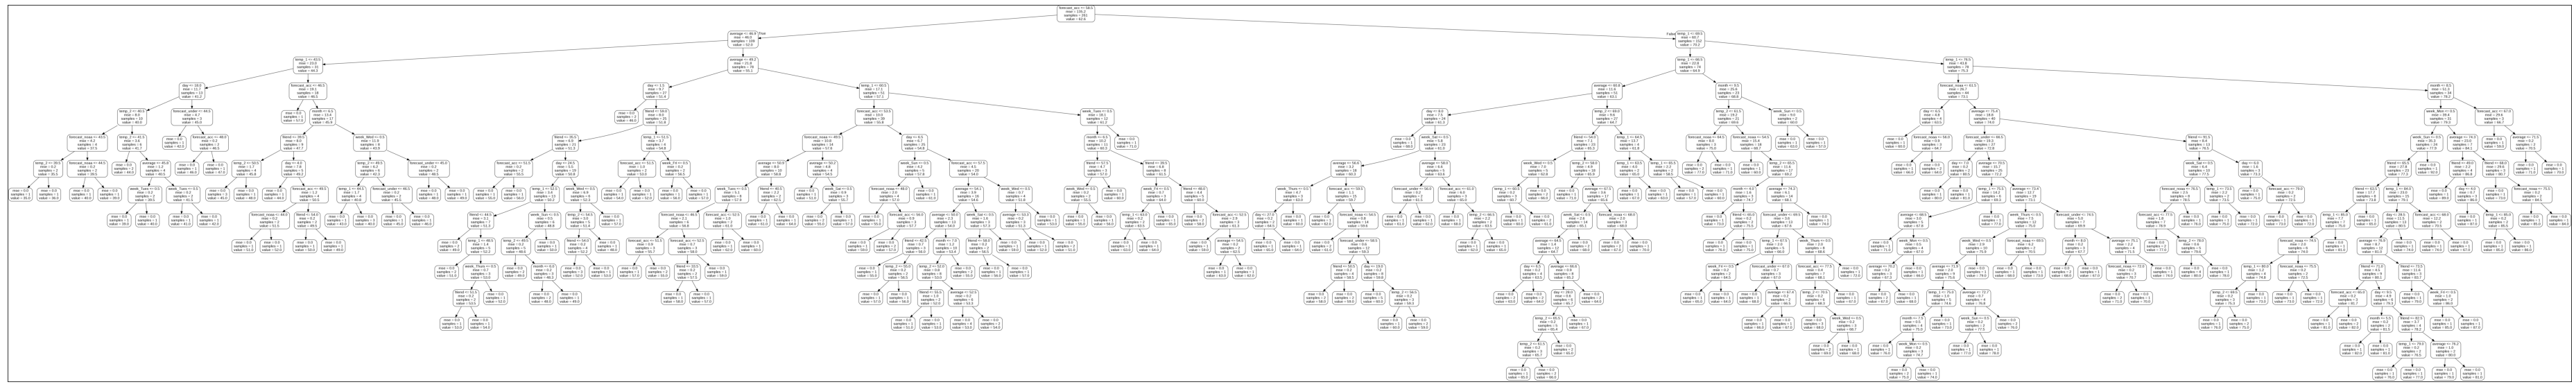

In [11]:
import matplotlib.pyplot as plt
def plot_decisiontree(img_name):
    tree_image = plt.imread(img_name)
    plt.figure(figsize=(100,10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(tree_image)
    plt.show()
plot_decisiontree('dtree_vanilla.png')

In [12]:
predictions = dtree_vanilla.predict(X_train)
errors = abs(predictions - y_train)
print("Mean Absolute Error for Train: ", round(np.mean(errors),2), " degrees")
predictions = dtree_vanilla.predict(X_test)
errors = abs(predictions - y_test)
print("Mean Absolute Error for test: ", round(np.mean(errors),2), " degrees")

Mean Absolute Error for Train:  0.0  degrees
Mean Absolute Error for test:  5.64  degrees


We see that the prediction for the training set is perfect, but the error for the testing set is large. This is as expected as we grow a full tree. A full tree will always yield zero error for the training set.

Now let us look at the feature ranking derived from this full tree. It is satisfying that features related to which day of the week, the date, month and year are not considered very important, although some of these features still have non-zero importance assigned. It is a little surprising that temp_2 is not considered important, only temp_1.

In [13]:
# Get numerical feature importances
importances = list(dtree_vanilla.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: forecast_acc         Importance: 0.61
Variable: temp_1               Importance: 0.17
Variable: average              Importance: 0.11
Variable: month                Importance: 0.02
Variable: forecast_noaa        Importance: 0.02
Variable: friend               Importance: 0.02
Variable: day                  Importance: 0.01
Variable: temp_2               Importance: 0.01
Variable: forecast_under       Importance: 0.01
Variable: week_Mon             Importance: 0.01
Variable: week_Sun             Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


### Random Forest
We now build a random forest with 100 decision trees and compare its performance with a single tree. We constrain each tree to have the same constraint as the previous tree.

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, min_samples_leaf=5, max_depth=5, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
predictions = rf.predict(X_train)
errors = abs(predictions - y_train)
print("Mean Absolute Error for Train: ", round(np.mean(errors),2), " degrees")
predictions = rf.predict(X_test)
errors = abs(predictions - y_test)
print("Mean Absolute Error for test: ", round(np.mean(errors),2), " degrees")

Mean Absolute Error for Train:  2.86  degrees
Mean Absolute Error for test:  3.4  degrees


We see that we got even lower prediction error for the testset. This is as expected, as we averaged results from many trees designed from different samplings of the original training data.  Now let us take a look at one of the trees.  

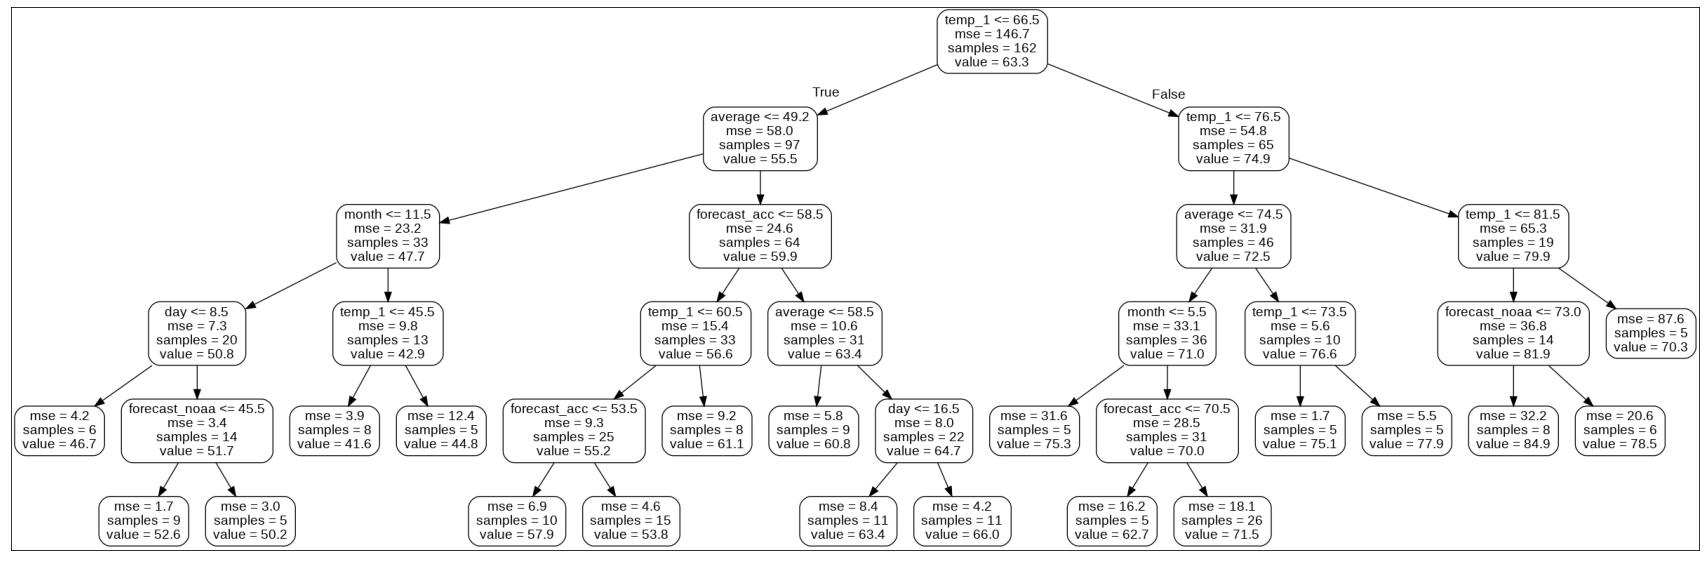

In [0]:
rf_tree = rf.estimators_[5]
export_graphviz(rf_tree, out_file = 'rf.dot', feature_names = feature_list, rounded = True, precision = 1)
# Write graph to a png file
(graph_rf, ) = pydot.graph_from_dot_file('rf.dot')
graph_rf.write_png('rf.png')
plot_decisiontree('rf.png')

Let us look at the importance of different features based on the random forest.

In [0]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.51
Variable: average              Importance: 0.21
Variable: forecast_acc         Importance: 0.21
Variable: forecast_noaa        Importance: 0.02
Variable: month                Importance: 0.01
Variable: day                  Importance: 0.01
Variable: temp_2               Importance: 0.01
Variable: friend               Importance: 0.01
Variable: year                 Importance: 0.0
Variable: forecast_under       Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


We see that the feature ranking changed from the single tree. We believe this ranking is more reliable. It ranked temp_1 (yesterday's temperature) as the most important, but give the most importance to the same three features as before. 